__Exploratory Data Analysis (EDA)__

- Inspect distributions, missing values, outliers.
- Plot time series of IV, skew, curvature.
- Compare SPY vs QQQ.
- Correlation checks.
- Document findings.

In [2]:
# import parquet_extractor  
# import importlib

# importlib.reload(parquet_extractor) 

In [15]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from parquet_extractor import load_ticker_year_data, get_ticker_metadata

__Load the filtered parquet__

In [4]:
metadata = get_ticker_metadata('SPY', Path("."))
metadata

{'ticker': 'SPY',
 'processing_config': {'date_range': {'from_date': '2023-01-01',
   'to_date': '2023-01-31'},
  'volume_percentile': 0.95,
  'batch_size': 75000},
 'data_statistics': {'volume_threshold': 6075.0,
  'total_records_raw': 476003,
  'total_records_written': 476003,
  'filter_retention_rate': 1.0,
  'years_available': [2023]},
 'files_created': ['options_data_partitioned/spy/spy_2023.parquet'],
 'processing_timestamp': '2025-09-22T00:52:57.153881',
 'schema': {'date': 'Date',
  'secid': 'Float64',
  'symbol': 'String',
  'cp_flag': 'String',
  'exdate': 'Date',
  'strike_price': 'Float64',
  'best_bid': 'Float64',
  'best_offer': 'Float64',
  'volume': 'Float64',
  'open_interest': 'Float64',
  'impl_volatility': 'Float64',
  'delta': 'Float64',
  'vega': 'Float64',
  'theta': 'Float64',
  'forward_price': 'Float64',
  'expiry_indicator': 'String',
  'prc': 'Float64',
  'vol': 'Float64',
  'year': 'Int32',
  'month': 'Int8',
  'day': 'Int8',
  'iv_30d': 'Float64',
  'price

In [5]:
def load_merged_ticker_data(tickers, start_year, end_year, data_dir=Path(".")):
    """Load and merge data for multiple tickers across a range of years."""
    all_data = []

    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        for year in range(start_year, end_year + 1):
            try:
                df = load_ticker_year_data(ticker, year, data_dir)
                df = df.with_columns([
                    pl.lit(ticker).alias("ticker"),
                ])
                all_data.append(df)
            except FileNotFoundError:
                print(f"Data not found for {ticker} in {year}, skipping.")
            except Exception as e:
                print(f"Error loading {ticker} in {year}: {e}")

    if all_data:
        return pl.concat(all_data)
    else:
        return pl.DataFrame()

In [6]:
spy_df = load_merged_ticker_data('SPY', 2016, 2023, Path(".")).to_pandas()
spy_df.sample(7)

,date,secid,symbol,cp_flag,exdate,strike_price,best_bid,best_offer,volume,open_interest,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,ticker
11725688,2021-10-19,109820.0,SPY 220318C432000,C,2022-03-18,432000.0,31.01,31.43,2.0,143.0,...,3.45001,3.45001,4.77001,4.77001,15.46002,17.02001,15.74002,16.19000,3.47000,SPY
14910723,2022-08-16,109820.0,SPY 220930C444000,C,2022-09-30,444000.0,4.62,4.66,67.0,1055.0,...,0.84002,0.84002,0.84002,2.60000,9.71002,16.23001,23.63000,34.93002,48.46002,SPY
14934841,2022-03-17,109820.0,SPY 230120C445000,C,2023-01-20,445000.0,30.45,33.96,32.0,3296.0,...,0.00000,0.00000,5.45001,5.45001,14.90000,21.00000,13.66001,3.18000,11.50000,SPY
15321166,2022-08-18,109820.0,SPY 221230C471000,C,2022-12-30,471000.0,4.10,4.19,6.0,921.0,...,1.24002,1.24002,-1.81000,7.90002,14.42001,17.12002,29.10000,61.24002,-13.18000,SPY
10523065,2021-08-17,109820.0,SPY 211217P372000,P,2021-12-17,372000.0,4.50,4.52,2.0,2807.0,...,0.00000,-1.88000,-1.88000,2.28000,2.28000,5.21002,12.70001,17.43002,29.10001,SPY
10005435,2021-02-22,109820.0,SPY 210630P325000,P,2021-06-30,325000.0,6.79,6.82,7.0,740.0,...,-3.00000,-3.00000,-3.69000,-5.36001,-3.04999,5.17999,16.95999,2.79001,13.48001,SPY
3961090,2018-11-07,109820.0,SPY 200117P285000,P,2020-01-17,285000.0,19.02,19.43,74.0,3239.0,...,0.00000,0.00000,5.89001,7.62000,9.12000,7.50000,13.24002,7.40002,5.06000,SPY


In [7]:
qqq_df = load_merged_ticker_data('QQQ', 2016, 2023, Path(".")).to_pandas()
qqq_df.sample(7)

,date,secid,symbol,cp_flag,exdate,strike_price,best_bid,best_offer,volume,open_interest,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,ticker
3000216,2021-09-07,107899.0,QQQ 211217P353000,P,2021-12-17,353000.0,7.56,7.62,361.0,1461.0,...,0.53998,0.53998,1.71000,2.15998,1.84998,8.87998,14.57999,20.54999,28.40000,QQQ
2167589,2020-08-10,107899.0,QQQ 200918P273000,P,2020-09-18,273000.0,10.45,10.51,446.0,864.0,...,-1.16000,-1.16000,-1.16000,-4.33001,-0.07000,4.51999,12.29999,9.94000,26.69000,QQQ
4436744,2023-04-26,107899.0,QQQ 230818P270000,P,2023-08-18,270000.0,4.40,4.44,21.0,6731.0,...,0.00000,0.00000,1.88001,-4.08001,-4.73999,-6.97000,-6.00000,-3.80999,23.32001,QQQ
4330188,2022-05-05,107899.0,QQQ 240119C610000,C,2024-01-19,610000.0,0.90,1.05,38.0,668.0,...,-16.60001,-5.82001,-5.48001,-0.25000,-4.14001,-28.20999,-41.10001,-38.48999,-16.42001,QQQ
3116913,2021-06-02,107899.0,QQQ 210820C370000,C,2021-08-20,370000.0,1.10,1.12,25.0,1335.0,...,0.64999,0.64999,0.64999,0.59000,6.45999,9.06000,-0.73001,-6.75000,-7.13001,QQQ
3971908,2022-09-09,107899.0,QQQ 220930C339000,C,2022-09-30,339000.0,0.34,0.35,46.0,1193.0,...,6.57001,6.57001,8.12000,14.04001,7.82001,-0.35000,-15.76999,-16.98999,18.04999,QQQ
4529059,2023-05-26,107899.0,QQQ 230721P292000,P,2023-07-21,292000.0,1.07,1.09,12.0,5501.0,...,8.67999,16.75000,16.75000,10.75998,11.88998,21.60998,32.22998,29.54000,37.50998,QQQ


__Inspect distributions, missing values, outliers__

In [8]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17375323 entries, 0 to 17375322
Data columns (total 37 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   secid              float64       
 2   symbol             object        
 3   cp_flag            object        
 4   exdate             datetime64[ns]
 5   strike_price       float64       
 6   best_bid           float64       
 7   best_offer         float64       
 8   volume             float64       
 9   open_interest      float64       
 10  impl_volatility    float64       
 11  delta              float64       
 12  vega               float64       
 13  theta              float64       
 14  forward_price      float64       
 15  expiry_indicator   object        
 16  prc                float64       
 17  vol                float64       
 18  iv_30d             float64       
 19  year               int32         
 20  vol_delta_product  flo

In [9]:
spy_df.isna().sum()

date                        0
secid                       0
symbol                      0
cp_flag                     0
exdate                      0
strike_price                0
best_bid                    0
best_offer                  0
volume                      0
open_interest               0
impl_volatility             0
delta                       0
vega                        0
theta                       0
forward_price        17375323
expiry_indicator     12799393
prc                         0
vol                         0
iv_30d                      0
year                        0
vol_delta_product           0
moneyness                   0
volume_ma5                  0
iv_rolling_std              0
price_diff_1d               0
price_diff_2d               0
price_diff_3d               0
price_diff_5d               0
price_diff_8d               0
price_diff_13d              0
price_diff_21d              0
price_diff_34d              0
price_diff_55d              0
price_diff

In [10]:
qqq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045603 entries, 0 to 5045602
Data columns (total 37 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   secid              float64       
 2   symbol             object        
 3   cp_flag            object        
 4   exdate             datetime64[ns]
 5   strike_price       float64       
 6   best_bid           float64       
 7   best_offer         float64       
 8   volume             float64       
 9   open_interest      float64       
 10  impl_volatility    float64       
 11  delta              float64       
 12  vega               float64       
 13  theta              float64       
 14  forward_price      float64       
 15  expiry_indicator   object        
 16  prc                float64       
 17  vol                float64       
 18  iv_30d             float64       
 19  year               int32         
 20  vol_delta_product  float

In [11]:
qqq_df.isna().sum()

date                       0
secid                      0
symbol                     0
cp_flag                    0
exdate                     0
strike_price               0
best_bid                   0
best_offer                 0
volume                     0
open_interest              0
impl_volatility            0
delta                      0
vega                       0
theta                      0
forward_price        5045603
expiry_indicator     3986113
prc                        0
vol                        0
iv_30d                     0
year                       0
vol_delta_product          0
moneyness                  0
volume_ma5                 0
iv_rolling_std             0
price_diff_1d              0
price_diff_2d              0
price_diff_3d              0
price_diff_5d              0
price_diff_8d              0
price_diff_13d             0
price_diff_21d             0
price_diff_34d             0
price_diff_55d             0
price_diff_89d             0
price_diff_144

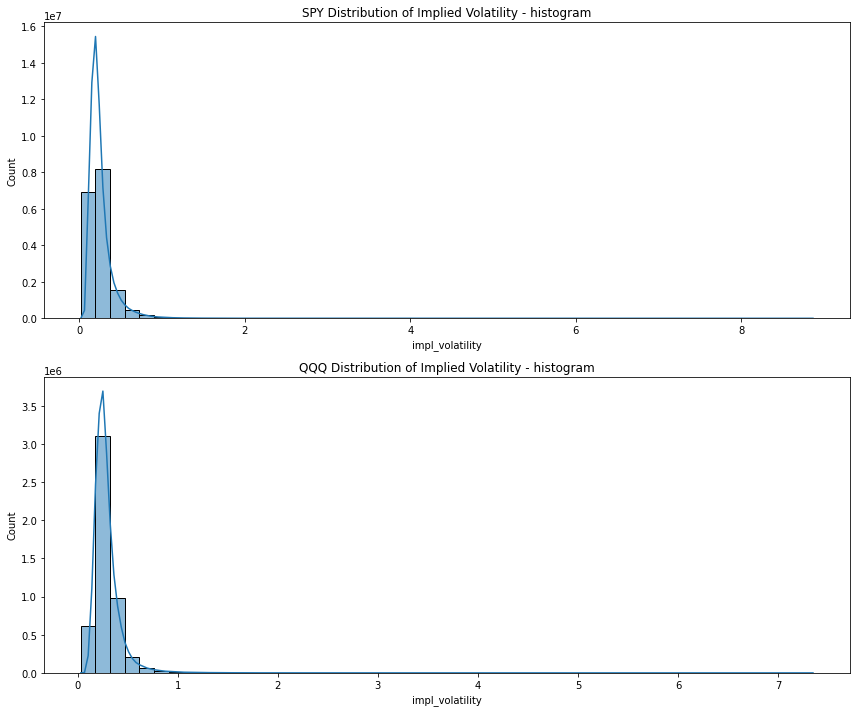

In [13]:
fig, axes = plt.subplots(2,1, figsize=(12,10))

# SPY Distribution of IV
sns.histplot(data=spy_df, x='impl_volatility', bins=50, kde=True, ax = axes[0])
axes[0].set_title("SPY Distribution of Implied Volatility - histogram")

# QQQ Distribution of IV
sns.histplot(data=qqq_df, x='impl_volatility', bins=50, kde=True, ax = axes[1])
axes[1].set_title("QQQ Distribution of Implied Volatility - histogram")


plt.tight_layout()
plt.show()

Implied volatility is concentrated between roughly 15% and 30%, with very few outliers above 30%. This suggests the dataset is clean after filtering. SPY and QQQ show broadly similar IV distributions, with QQQ’s median only slightly higher, reflecting modest sector risk differences. Outliers above 0.3 may represent short‑term stress events or occasional bad quotes, but they are rare and do not dominate the distribution.

__Aggregate daily features (ATM IV, skew, curvature)__

In [17]:
def extract_iv_features(df):
    """Extract volatility surface and market dynamics features from DataFrame (df)."""
    features = []

    # Group by date and ticker
    for (date, ticker), group in df.groupby(['date', 'ticker']):
        group = group.copy()

        # --- ATM IV ---
        atm_row = group.iloc[(group['delta'].abs() - 0.5).abs().argsort()[:1]]
        atm_iv = atm_row['impl_volatility'].values[0]

        # --- 25-delta put and call ---
        put25 = group[group['cp_flag'] == 'P']
        call25 = group[group['cp_flag'] == 'C']

        if not put25.empty and not call25.empty:
            put25_idx = (put25['delta'] + 0.25).abs().idxmin()
            call25_idx = (call25['delta'] - 0.25).abs().idxmin()

            iv_put25 = group.loc[put25_idx, 'impl_volatility']
            iv_call25 = group.loc[call25_idx, 'impl_volatility']

            skew = iv_put25 - iv_call25
            curvature = (iv_put25 + iv_call25) / 2 - atm_iv
        else:
            skew = curvature = np.nan

        # --- Volatility-of-volatility ---
        group_sorted = group.sort_values('exdate')
        iv_std = group_sorted['impl_volatility'].std()

        # --- Greeks (averaged) ---
        avg_delta = group['delta'].mean()
        avg_vega = group['vega'].mean()
        avg_theta = group['theta'].mean()

        # --- Price momentum ---
        price_momentum = {
            f"price_diff_{d}d": group[f"price_diff_{d}d"].mean()
            for d in [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233]
            if f"price_diff_{d}d" in group.columns
        }

        features.append({
            'date': date,
            'ticker': ticker,
            'ATM_IV': atm_iv,
            'Skew': skew,
            'Curvature': curvature,
            'IV_std': iv_std,
            'Avg_Delta': avg_delta,
            'Avg_Vega': avg_vega,
            'Avg_Theta': avg_theta,
            **price_momentum
        })

    return pd.DataFrame(features)

In [19]:
spy_features = extract_iv_features(spy_df)
spy_features.sample(7)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_3d,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d
395,2017-09-13,SPY,0.101732,0.061982,0.003014,0.091073,0.035245,41.345866,-7.734638,0.040260,...,0.122063,0.205148,0.376326,0.821610,1.954949,3.167329,3.732372,4.444123,5.530343,5.471479
1597,2022-10-17,SPY,0.243692,0.058773,0.021077,0.157593,-0.048858,48.410297,-30.661671,0.862128,...,2.603937,4.363300,6.102892,6.027023,5.177075,5.473251,1.442628,-4.161431,-6.931483,-24.880875
88,2016-06-02,SPY,0.151651,0.068713,-0.011834,0.088389,0.029367,31.666022,-8.851248,0.075312,...,0.227047,0.379892,0.583328,0.839967,1.054735,1.574531,3.044980,5.196767,4.908572,4.845357
1659,2023-02-08,SPY,0.179152,0.063622,0.006304,0.078671,0.135243,57.342416,-35.380848,-0.358547,...,-1.103037,-1.874926,-2.775276,-3.370279,-1.176923,-1.415479,-2.236463,7.243866,12.798982,18.511636
1190,2021-02-11,SPY,0.214250,0.041430,-0.043852,0.086160,0.139029,56.336105,-28.610029,0.052769,...,0.162467,0.276326,0.418957,0.565162,0.552359,1.212847,5.109571,12.272252,10.289400,13.327302
1449,2022-03-16,SPY,0.214294,0.103353,0.012838,0.247709,-0.013801,58.533312,-41.499621,1.020688,...,3.085462,5.173633,8.055854,12.100801,14.995534,13.983838,9.705760,6.953496,-0.957409,-8.176372
334,2017-06-16,SPY,0.143128,0.077028,-0.026750,0.076533,0.091938,35.599833,-6.319858,-0.117845,...,-0.355333,-0.594619,-0.902520,-1.252644,-1.378073,-1.094328,-0.430938,0.408773,2.361616,4.837575


In [20]:
qqq_features = extract_iv_features(qqq_df)
qqq_features.sample(7)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_3d,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d
308,2017-05-31,QQQ,0.119751,0.083309,0.019104,0.055336,0.195209,16.589962,-5.626976,0.003456,...,0.010369,0.016827,0.072512,0.232711,0.676969,1.864558,3.169408,3.701828,5.120273,9.161292
1572,2022-11-18,QQQ,0.274180,0.069737,0.013011,0.084917,0.023248,40.127731,-23.290104,-0.003554,...,-0.010663,-0.018030,-0.263904,-0.765588,-0.836798,2.619605,10.522970,13.909485,7.997666,6.691752
573,2018-07-23,QQQ,0.157643,0.086687,0.008887,0.053724,0.199783,24.627082,-10.760235,0.075494,...,0.226482,0.384940,0.433162,0.448273,0.339042,0.643563,2.113241,5.280473,7.074816,8.072164
545,2018-06-12,QQQ,0.137146,0.062519,0.031137,0.168065,0.200956,21.742799,-10.197549,0.127041,...,0.381124,0.639626,0.914136,1.187605,1.410451,1.731822,4.214076,7.352210,9.605768,12.321310
1253,2021-07-14,QQQ,0.212905,0.047001,-0.018788,0.156275,0.117736,56.000689,-22.085688,0.115909,...,0.347726,0.581772,0.889563,1.442029,2.669727,5.016960,8.846054,16.082048,24.926932,33.737038
208,2016-12-01,QQQ,0.184688,0.078939,-0.000731,0.083126,0.058449,14.972565,-6.422754,-0.304575,...,-0.913724,-1.532207,-2.167931,-2.836866,-3.052874,-2.765280,-2.129088,-0.951195,-0.918789,-1.055410
739,2019-04-24,QQQ,0.151422,0.052553,0.007505,0.083373,0.231004,22.945660,-11.451118,-0.045864,...,-0.137593,-0.233422,0.085903,1.046918,2.389937,3.311101,4.745050,6.564007,10.841396,15.758359


Pull in the TBills Secondary Market 3-month (dtb3) and Treasury Constant Maturity 2-year (dgs2) from WRDS FRB and join by date

In [ ]:
# db = wrds.Connection(wrds_username='ayansola')
# setup pg_pass needed for access to the wrds dataset (first time only)
# db.create_pgpass_file()

In [ ]:
# params = {
#     "from_date": "2022-01-01",
#     "to_date": "2023-12-31"
# }

# t_bill = db.raw_sql(
#     """
#     SELECT date, dtb3 as tbills_3m, dgs2 as treasury_2y
#     FROM frb.rates_daily
#     WHERE date BETWEEN %(from_date)s AND %(to_date)s
#     """,
#     params=params,
# )

In [ ]:
# t_bill.dtypes

In [ ]:
# t_bill['date'] = pd.to_datetime(t_bill['date'])

In [ ]:
# t_bill.info()

In [ ]:
# t_bill.head()

In [ ]:
# features_df = features_df.merge(t_bill[['date','tbills_3m', 'treasury_2y']], on='date', how='left')

In [ ]:
# features_df.head()

__Plot time series of ATM_IV, skew, curvature, IV_std, Avg_Vega & Price_diff_21d for SPY & QQQ__

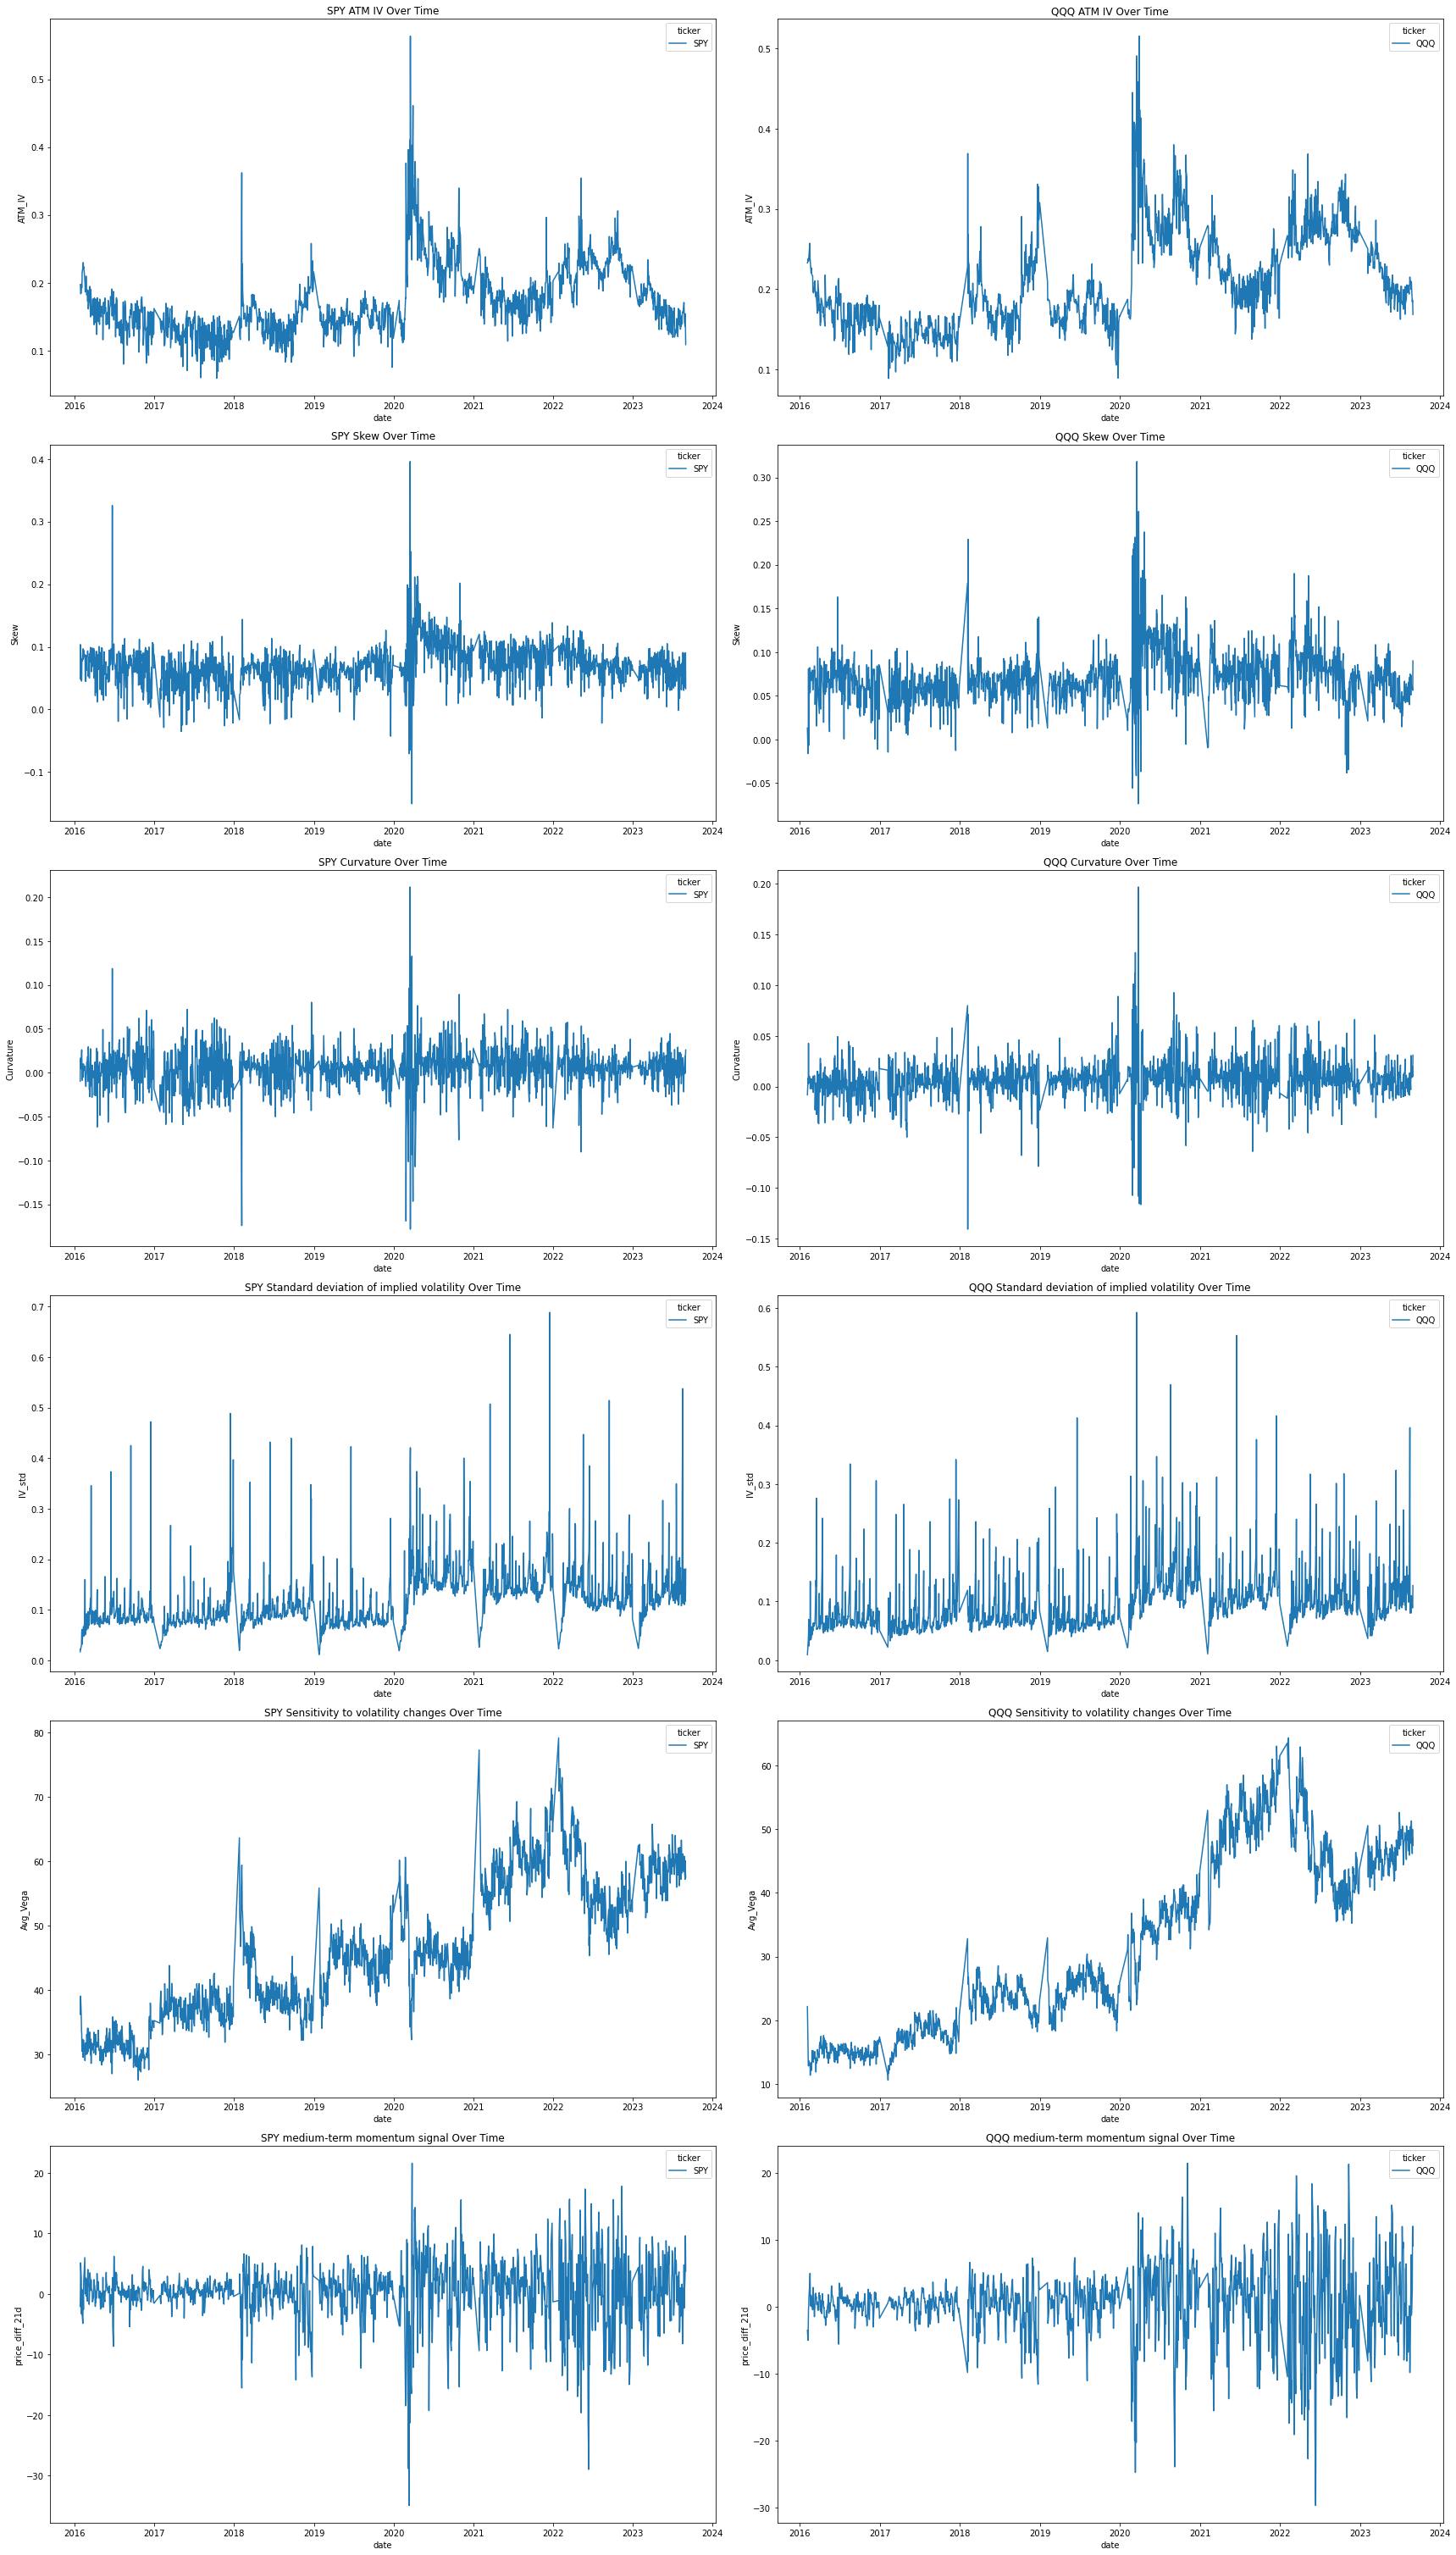

In [30]:
fig, axes = plt.subplots(6,2, figsize=(24,42))

sns.lineplot(data=spy_features, x='date', y='ATM_IV', hue='ticker', ax = axes[0, 0])
axes[0, 0].set_title("SPY ATM IV Over Time")

sns.lineplot(data=qqq_features, x='date', y='ATM_IV', hue='ticker', ax = axes[0, 1])
axes[0, 1].set_title("QQQ ATM IV Over Time")

sns.lineplot(data=spy_features, x='date', y='Skew', hue='ticker', ax = axes[1, 0])
axes[1, 0].set_title("SPY Skew Over Time")

sns.lineplot(data=qqq_features, x='date', y='Skew', hue='ticker', ax = axes[1, 1])
axes[1, 1].set_title("QQQ Skew Over Time")

sns.lineplot(data=spy_features, x='date', y='Curvature', hue='ticker', ax = axes[2, 0])
axes[2, 0].set_title("SPY Curvature Over Time")

sns.lineplot(data=qqq_features, x='date', y='Curvature', hue='ticker', ax = axes[2, 1])
axes[2, 1].set_title("QQQ Curvature Over Time")

sns.lineplot(data=spy_features, x='date', y='IV_std', hue='ticker', ax = axes[3, 0])
axes[3, 0].set_title("SPY Standard deviation of implied volatility Over Time")

sns.lineplot(data=qqq_features, x='date', y='IV_std', hue='ticker', ax = axes[3, 1])
axes[3, 1].set_title("QQQ Standard deviation of implied volatility Over Time")

sns.lineplot(data=spy_features, x='date', y='Avg_Vega', hue='ticker', ax = axes[4, 0])
axes[4, 0].set_title("SPY Sensitivity to volatility changes Over Time")

sns.lineplot(data=qqq_features, x='date', y='Avg_Vega', hue='ticker', ax = axes[4, 1])
axes[4, 1].set_title("QQQ Sensitivity to volatility changes Over Time")

sns.lineplot(data=spy_features, x='date', y='price_diff_21d', hue='ticker', ax = axes[5, 0])
axes[5, 0].set_title("SPY medium-term momentum signal Over Time")

sns.lineplot(data=qqq_features, x='date', y='price_diff_21d', hue='ticker', ax = axes[5, 1])
axes[5, 1].set_title("QQQ medium-term momentum signal Over Time")

# sns.lineplot(data=features_df, x='date', y='tbills_3m', ax = axes[3])
# axes[3].set_title("3 month TBills Secondary Market Over Time")

# sns.lineplot(data=features_df, x='date', y='treasury_2y', ax = axes[4])
# axes[4].set_title("Treasury Constant Maturity 2-year Over Time")


# sns.lineplot(data=features_df, x='date', y='dtb1yr', ax = axes[3])
# axes[6].set_title("1 year TBills Secondary Market Over Time")

plt.tight_layout()
plt.show()

- Both symbols experience occasional, brief volatility spikes, with QQQ’s being more pronounced.

- QQQ’s skew is more volatile and often higher, pointing to increased demand for put options

- Curvature is persistently positive for both

- Implied volatility doesn’t track with short‑term rates like the 3‑month bill, but it does respond more visibly to shifts in the 2‑year yield as seen above

In [ ]:
# drop dtb3 since IV doesn't track with it
# features_df = features_df.drop(columns=['tbills_3m'])

__Correlation checks__

In [33]:
# metrics = ['ATM_IV', 'Skew', 'Curvature']

# for metric in metrics:
#     pivot = features_df.pivot(index='date', columns='ticker', values=metric)
#     corr = pivot.corr()
#     sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
#     plt.title(f"Correlation of {metric} between SPY and QQQ")
#     plt.show()

In [36]:
spy_features.isna().sum()

date               0
ticker             0
ATM_IV             0
Skew               0
Curvature          0
IV_std             0
Avg_Delta          0
Avg_Vega           0
Avg_Theta          0
price_diff_1d      0
price_diff_2d      0
price_diff_3d      0
price_diff_5d      0
price_diff_8d      0
price_diff_13d     0
price_diff_21d     0
price_diff_34d     0
price_diff_55d     0
price_diff_89d     0
price_diff_144d    0
price_diff_233d    0
dtype: int64

In [37]:
qqq_features.isna().sum()

date               0
ticker             0
ATM_IV             0
Skew               0
Curvature          0
IV_std             0
Avg_Delta          0
Avg_Vega           0
Avg_Theta          0
price_diff_1d      0
price_diff_2d      0
price_diff_3d      0
price_diff_5d      0
price_diff_8d      0
price_diff_13d     0
price_diff_21d     0
price_diff_34d     0
price_diff_55d     0
price_diff_89d     0
price_diff_144d    0
price_diff_233d    0
dtype: int64

Volatility levels between SPY and QQQ are highly synchronized, skew is moderately aligned but allows for divergence, and curvature behaves almost independently.

In [34]:
series = spy_features['ATM_IV']
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.2299333529643843
p-value: 0.018316097555224193


In [35]:
series = qqq_features['ATM_IV']
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.9331498615375207
p-value: 0.041626697028126075


### EDA Summary
- **Data quality:** No major missing values.
- **Distributions:** SPY && QQQ IV show broadly similar distributions with SPY IV centered lower than QQQ
- **Time series:** Both symbols show volatility spikes around market stress dates.
- **Correlations:** ATM IV highly correlated (SPY vs QQQ ~0.8).

__Save Aggregate daily features to Parquet: partition by symbol/year for downstream use.__

In [ ]:
features_df['year'] = pd.to_datetime(features_df['date']).dt.year

# Write to Parquet with partitioning
features_df.to_parquet(
    "features_parquet/",
    engine="fastparquet",        # or "pyarrow"
    partition_cols=["ticker", "year"],
    index=False
)